
# Machine Learning & AI: Practice 2

-----------


<br><br>

<h3><div style="text-align: center"> 한양대학교 에리카, AI Lab <br><br>
이상근 </div> </h3>


## Prepare gene expression data

In [1]:
import os
import pandas as pd

matrix1 = pd.read_table('./data/brca_expression_5yr_survive.tsv', index_col=0)
matrix2 = pd.read_table('./data/brca_expression_5yr_dead.tsv', index_col=0)
print(matrix1.shape)
print(matrix2.shape)

(19785, 123)
(19785, 30)


In [2]:
matrix = pd.concat([matrix1, matrix2], axis=1)
print(matrix.shape)
#matrix

(19785, 153)


## Select top 2000 genes with differential expression

In [3]:
num_variables = 2000

expr_var = matrix.var(axis=1)
expr_var_sorted = expr_var.sort_values(ascending=False)
top_names = expr_var_sorted[0:num_variables]
#print(top_names)

In [4]:
matrix = matrix.loc[top_names.index]
matrix1 = matrix1.loc[top_names.index]
matrix2 = matrix2.loc[top_names.index]
print(matrix1.shape, matrix2.shape, matrix.shape)

(2000, 123) (2000, 30) (2000, 153)


## Split the data into training and test set

In [5]:
import numpy as np

# set seed for random number generator
seed = 0
np.random.seed(seed)

# select 30% of each group as test data
sel1 = np.random.choice(matrix1.shape[1], size=41, replace=False)
sel2 = np.random.choice(matrix2.shape[1], size=10, replace=False)

test = pd.concat([matrix1.iloc[:, sel1], matrix2.iloc[:, sel2]], axis=1)

# drop the samples from the tables
matrix1.drop(matrix1.columns[sel1], axis=1, inplace=True)
matrix2.drop(matrix2.columns[sel2], axis=1, inplace=True)
matrix = pd.concat([matrix1, matrix2], axis=1)
print(matrix1.shape, matrix2.shape, matrix.shape, test.shape)


(2000, 82) (2000, 20) (2000, 102) (2000, 51)


## Row: Samples, Columnes: Attributes

In [6]:
matrix = matrix.T
test = test.T

## Data Pre-processing: Standardization

In [7]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(matrix.values) # not on the test set
genenames = np.array(matrix.columns)
print(genenames)
X_train = matrix.values
X_test = test.values
X_train_std = sc.transform(matrix.values)
X_test_std = sc.transform(test.values)

y_train = np.r_[matrix1.shape[1]*[0], matrix2.shape[1]*[1]]
y_test = np.r_[sel1.size*[0], sel2.size*[1]]
y_test

['SCGB2A2' 'SCGB1D2' 'TFF1' ..., 'GPC6' 'LYPD6' 'GIMAP2']


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1])

## Classification with Logistic Regression

In [28]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(C=1.0, random_state=0)
lr.fit(X_train_std, y_train)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [29]:
from sklearn.metrics import accuracy_score

y_pred = lr.predict(X_train_std)
print('Train-set Accuracy: %.2f' % accuracy_score(y_train, y_pred))
y_pred = lr.predict(X_test_std)
print('Test-set Accuracy: %.2f' % accuracy_score(y_test, y_pred))

Train-set Accuracy: 1.00
Test-set Accuracy: 0.63


## Classification with SVM

In [32]:
from sklearn.svm import SVC

svm = SVC(kernel='linear', random_state=0, C=1.0)
svm.fit(X_train_std, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False)

In [33]:
y_pred = svm.predict(X_train_std)
print('Train-set Accuracy: %.2f' % accuracy_score(y_train, y_pred))
y_pred = svm.predict(X_test_std)
print('Test-set Accuracy: %.2f' % accuracy_score(y_test, y_pred))

Train-set Accuracy: 1.00
Test-set Accuracy: 0.78


## Classification with Kernel SVM

In [47]:
from sklearn.svm import SVC

svm = SVC(kernel='rbf', random_state=0, gamma=0.1, C=1.0)
svm.fit(X_train_std, y_train)

y_pred = svm.predict(X_train_std)
print('Train-set Accuracy: %.2f' % accuracy_score(y_train, y_pred))
y_pred = svm.predict(X_test_std)
print('Test-set Accuracy: %.2f' % accuracy_score(y_test, y_pred))

Train-set Accuracy: 1.00
Test-set Accuracy: 0.80


## Classification with Decision Tree

In [51]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion='entropy', max_depth=10, random_state=0)
tree.fit(X_train, y_train)

y_pred = tree.predict(X_train)
print('Train-set Accuracy: %.2f' % accuracy_score(y_train, y_pred))
y_pred = tree.predict(X_test)
print('Test-set Accuracy: %.2f' % accuracy_score(y_test, y_pred))

Train-set Accuracy: 1.00
Test-set Accuracy: 0.69


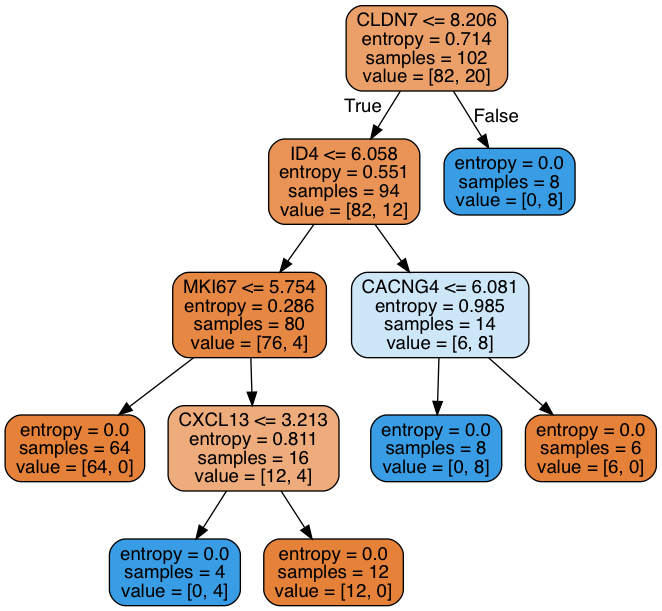

In [52]:
from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import Image
%matplotlib inline
        
dot_data = export_graphviz(tree,  out_file=None, feature_names=genenames, 
                           filled=True, rounded=True)
graph = pydotplus.graph_from_dot_data(dot_data)  
display(Image(graph.create_png()))

## Random Forest

In [53]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(criterion='entropy', n_estimators=1000, 
                                max_features=2, #auto, sqrt, log2, None
                                max_depth=None, random_state=1, n_jobs=2)
forest.fit(X_train, y_train)

y_pred = forest.predict(X_train)
print('Train-set Accuracy: %.2f' % accuracy_score(y_train, y_pred))
y_pred = forest.predict(X_test)
print('Test-set Accuracy: %.2f' % accuracy_score(y_test, y_pred))

Train-set Accuracy: 1.00
Test-set Accuracy: 0.80


## PCA Analysis

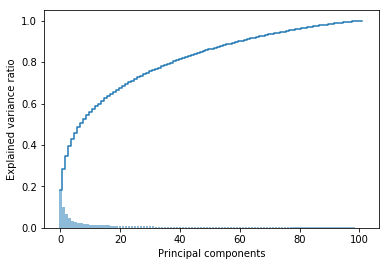

In [54]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA()
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

vals = pca.explained_variance_ratio_[:]

plt.bar(range(0, vals.size), vals, alpha=0.5, align='center')
plt.step(range(0, vals.size), np.cumsum(vals), where='mid')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.show()

(102, 10)


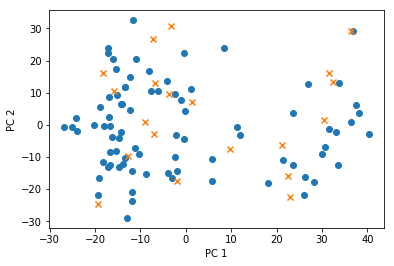

In [55]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

print(X_train_pca.shape)

#plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1])
plt.scatter(X_train_pca[y_train==0, 0], X_train_pca[y_train==0, 1], marker='o')
plt.scatter(X_train_pca[y_train==1, 0], X_train_pca[y_train==1, 1], marker='x')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()


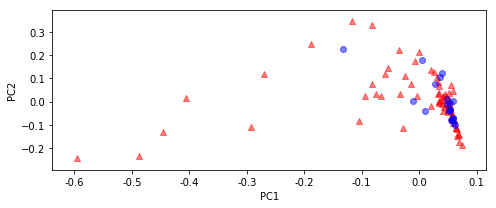

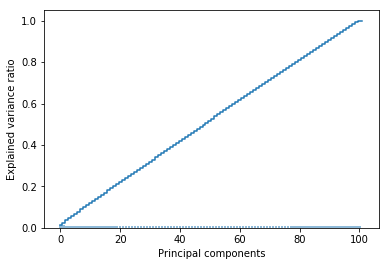

In [56]:
from sklearn.decomposition import KernelPCA
from matplotlib.ticker import FormatStrFormatter

scikit_kpca = KernelPCA(kernel='rbf', gamma=.002) #n_components=2, 
X_kpca = scikit_kpca.fit_transform(X_train_std)

fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(7,3))
ax.scatter(X_kpca[y_train==0, 0], X_kpca[y_train==0, 1], color='red', marker='^', alpha=0.5)
ax.scatter(X_kpca[y_train==1, 0], X_kpca[y_train==1, 1], color='blue', marker='o', alpha=0.5)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.xaxis.set_major_formatter(FormatStrFormatter('%0.1f'))
plt.tight_layout()
plt.show()

vals = scikit_kpca.lambdas_[:] / sum(scikit_kpca.lambdas_)
plt.bar(range(0, vals.size), vals, alpha=0.5, align='center')
plt.step(range(0, vals.size), np.cumsum(vals), where='mid')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.show()